In [1]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
%matplotlib inline

# Minimum funkcije in algoritem BFGS

Iščemo mimum funkcije $(\theta_0-2)^2+(\theta_1-3)^2-42$. Funkcijo in njen gradient zapišemo tako, da ima kot parametre vektor $\theta$.

In [2]:
def cost(theta):
    return (theta[0]-2)**2 + (theta[1]-3)**2 - 42

def grad(theta):
    return np.array([2*(theta[0]-2), 2*(theta[1]-3)])

In [3]:
theta = np.array([0, 0])
cost(theta), grad(theta)

(-29, array([-4, -6]))

Za iskanje minimuma uporabimo funkcijo ```fmin_l_bfgs_b``` ki implementira algoritem [Broyden–Fletcher–Goldfarb–Shanno z omejenim spominom](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

In [4]:
theta0 = np.array([0, 0])
res = fmin_l_bfgs_b(cost, theta0, grad)
res

(array([ 2.,  3.]),
 -42.0,
 {'funcalls': 3,
  'grad': array([ 0.,  0.]),
  'nit': 2,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

Rezultati se ujemajo s pričakovanji. Naša cenovna funkcija ima minimum v točki [2, 3], vrednost funkcije v tej točki je -17, konvergenca algoritma pa je izjemno hitra, saj je postopek našel minimum s samo tremi klici kriterijske funkcije in njenega gradienta.

# Metoda končnih razlik

Vedno je dobro preveriti, ali smo funkcijo, ki izračuna gradient, implementirali pravilno oziroma ali je analitična rešitev (izračun gradienta). Analitično izračunani in implementirani gradient kriterijske funkcije lahko primerjamo z  gradientom, ki ga izračunamo z metodo končnih razlik. Gradient računamo pri izbrani vrednosti parametrov $\theta$. Če bi imeli opravka s funkcijo enega samega parametra, bi z metodo končnih razlik odvod ocenili kot $f((\theta+\epsilon)-f(\theta-\epsilon)/(2\epsilon)$. Ker pa imamo opravka s kriterijsko funkcijo več parametrov ($\Theta$ je vektor), njene parcialne odvode izračunamo tako, da vsakič spreminjamo enega izmed parametrov.

In [5]:
def grad_approx(f, theta, e=1e-3):
    return np.array([(f(theta+eps) - f(theta-eps))/(2*e)
                     for eps in np.identity(len(theta)) * e])

In [6]:
grad_approx(cost, theta0), grad(theta0)

(array([-4., -6.]), array([-4, -6]))

Dela! Gradienta sta enaka. Seveda bo pri bolj kompleksnih kriterijskih funkcijah ta enakost približna in tudi odvisna od vrednosti premika $\epsilon$. Opazimo tudi, da je ta v naši implementaciji za vse atribute enak, kar ni ravno optimalno in bi bilo bolje, če bi atributi izraženi na isti merski lestvici, torej če bi bili normirani.

# Linearna regresija

Algoritma L-BFGS sedaj uporabimo za linearno regresijo. Za podatke uporabimo zbirko housing.

In [7]:
import Orange
data = Orange.data.Table("housing")
print("Examples: %d" % len(data))
print("Attributes: %d" % len(data.domain.attributes))

Examples: 506
Attributes: 13


Orange-ov objekt `data` vsebuje opis spremenljivk ter dve tabeli, tabelo atributov $X$ in vektor razredov $y$. Ker bomo tu potrebovali samo ta dva zapisa, in ker sta ta že v zapisu numpy, uvedemo novi spremenljivki, ki kažeta na te objekte. Matriko $X$ razširimo s kolono enic za računanje $\theta_0$.

In [8]:
X, y = data.X, data.Y
X = np.column_stack((np.ones(len(X)), X))

Izpišemo prva dva primera iz učne množice in dimenzije matrike X in vektorja y.

In [9]:
X[:2]

array([[  1.00000000e+00,   6.32000000e-03,   1.80000000e+01,
          2.31000000e+00,   0.00000000e+00,   5.38000000e-01,
          6.57500000e+00,   6.52000000e+01,   4.09000000e+00,
          1.00000000e+00,   2.96000000e+02,   1.53000000e+01,
          3.96900000e+02,   4.98000000e+00],
       [  1.00000000e+00,   2.73100000e-02,   0.00000000e+00,
          7.07000000e+00,   0.00000000e+00,   4.69000000e-01,
          6.42100000e+00,   7.89000000e+01,   4.96710000e+00,
          2.00000000e+00,   2.42000000e+02,   1.78000000e+01,
          3.96900000e+02,   9.14000000e+00]])

In [10]:
X.shape, y.shape

((506, 14), (506,))

Za linearno regresijo zapišemo cenovno funkcijo in funkcijo, ki vrača gradient.

In [11]:
def J(theta, X, y):
    return (1 / (2 * len(data))) * np.sum((X.dot(theta) - y)**2)

def grad(theta, X, y):
    return (1 / len(data)) * (X.dot(theta) - y).dot(X)

Preverimo izračun gradienta. Kriterijska funkcija J ima za argumente theto, opis primerov in razredni vektor, grad_approx pa kliče funkcijo, za katero računa gradient, samo z theto. Problem rešimo z novo funkcijo s privzetimi argumenti, ki jo uvedemo s konstruktom lambda.

In [12]:
theta = np.random.rand(X.shape[1])
g = grad(theta, X, y)
gp = grad_approx(lambda t, X=X, y=y: J(t, X, y), theta)
g, gp, np.sum(np.abs(g - gp))

(array([  3.35213760e+02,   1.72940925e+03,   2.89336210e+03,
          4.26879435e+03,   2.25228442e+01,   1.94350160e+02,
          2.07986167e+03,   2.47991490e+04,   1.14535166e+03,
          3.96326488e+03,   1.53197399e+05,   6.29560114e+03,
          1.16701488e+05,   4.70805337e+03]),
 array([  3.35213760e+02,   1.72940925e+03,   2.89336210e+03,
          4.26879435e+03,   2.25228442e+01,   1.94350160e+02,
          2.07986167e+03,   2.47991490e+04,   1.14535166e+03,
          3.96326488e+03,   1.53197399e+05,   6.29560114e+03,
          1.16701488e+05,   4.70805337e+03]),
 3.9360624981554793e-08)

Optimizacija

In [13]:
theta0 = np.zeros(X.shape[1])

In [14]:
res = fmin_l_bfgs_b(J, x0=theta0, args=(X, y), fprime=grad)
res

(array([  3.57967712e+01,  -1.08093081e-01,   4.66882362e-02,
          2.13456086e-02,   2.64074512e+00,  -1.77178974e+01,
          3.85310804e+00,   8.50473295e-04,  -1.47132044e+00,
          3.03650373e-01,  -1.22674708e-02,  -9.38811529e-01,
          9.42404540e-03,  -5.22704439e-01]),
 10.948023361492092,
 {'funcalls': 2557,
  'grad': array([-0.00088407, -0.00499033,  0.00982557,  0.00709474, -0.00335345,
         -0.00076431,  0.0021781 ,  0.03443767,  0.00132969,  0.00575186,
          0.30465147,  0.02588604,  0.21551422,  0.0034818 ]),
  'nit': 2212,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

Tudi tu je, glede na velikost podatkov, konvergenca hitra. Ne vemo sicer, kako dober je model. V tej točki bi morali oceniti napovedno točno modela (prečno preverjanje) ter pregledati, ali je model skladen z domenskim znanjem oziroma ali so uteži atributov ($\Theta$) smiselne. Za končno uporabo in interpretacijo bi morali podatke ustrezno normalizirati (vsaki koloni odštejemo povprečne vrednosti in delimo s standardno deviacijo).

Lahko pa vseeno izračunamo, kako dober je naš model na učnih podatkih. Parametri linearne regresije so shranjeni kot prvi element terke, ki ga vrne ```fmin_l_bfgs_b```.

In [15]:
theta = res[0]
y_hat = X.dot(theta)
rmse = np.sqrt(np.sum((y - y_hat)**2)/len(y))
rmse

4.6793211818579179

RMSE, kot številka, nam ne pove prav dosti. Poznati moramo domeno. Podatki, ki jih uporabljamo, govorijo o cenah hiš, napaka 4.6 pa v tisočih dolarjih na prvi pogled ne izgleda ravno velika. A kakšna bi bila napaka, če bi namesto našega linearnega napovednega modela uporabili kar povprečno vrednost spremenljivke y iz učne množice?

In [16]:
y_mean = np.sum(y) / len(y)
np.sqrt(np.sum((y - y_mean)**2)/len(y))

9.1880115452782025

Napaka linearni model na učni množici je torej precej manjša. V statistiki poznamo zanimivo mero, ki ji pravimo [delež razložene variance](https://en.wikipedia.org/wiki/Coefficient_of_determination) oziroma koeficient določenosti. Varianca je mera statistične razpršenosti naključne spremenljivke, oziroma povprečno kvadratno odstopanje od povprečne vrednosti naključne spremenljivke. Pravimo, da dober model za vse primere to odstopanje dobro pojasni oziroma ga napove, torej za vsak posamezen primere dobro napove, kako njegova razredna vrednost odstopa od njenega povprečja. Delež razložene variance zato to odstopanje modela zmeri in ga normira z varianco okoli povprečne vrednosti ter dobljeno vrednost odšteje od 1. Delež razložene ima vrednost 1.0 (100%) za modele, ki napovedujejo brez napak, ter 0.0 (0%) za modele, katerih napoved je kar povprečna vrednost.

In [17]:
ss_tot = np.sum((y-y_mean)**2) # total sum of squares
ss_res = np.sum((y-y_hat)**2) # residual sum of squares
r2 = 1 - ss_res / ss_tot # coefficient of determination
r2

0.74062826529815839

Naš model razloži 74% variance, kar je soliden rezultat. Popoln model bi razložil 100% variance, slab model, torej tak, ki bi napovedoval kar s povprečnimi vrednostmi, pa na razloži ničesar in je njegov $R^2=0$. 

## Preiskus delovanja na sintetični podatkih

Tu preverimo delovanje linearne regresije, kot smo jo implementirali, na sintetičnih podatkih. In sicer bomo te generirali za funkcijo $y=3x+42$, kjer pa bomo poleg kolone z vrednostjo $x$ dodali tudi kolono z naključnimi števili. Lahko bi takih, naključnih kolon dodali več, a bomo to prepustili bralcu.

In [18]:
m = 10
xs = np.arange(0, m, 1)
y = (3 * xs + 42)  + np.random.normal(0, 3, m)
X = np.array([[i, np.random.rand()*m] for i in xs])
X = np.column_stack((np.ones(len(X)), X))

In [19]:
theta0 = np.zeros(X.shape[1])
res = fmin_l_bfgs_b(J, x0=theta0, args=(X, y), fprime=grad)
res

(array([ 41.23181417,   2.77063114,   0.37209097]),
 0.057351124442747578,
 {'funcalls': 13,
  'grad': array([ -3.36323214e-09,  -1.73500777e-08,  -2.30144741e-08]),
  'nit': 11,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

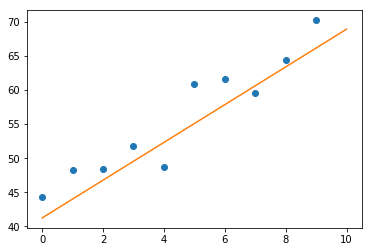

In [20]:
plt.plot(X[:, 1], y, "o")
p = np.array([[1, 0, 0], [1, 10, 0]])
plt.plot(p[:, 1], p.dot(res[0]));

Dela. Tudi parametre modela kar dobro zadane, glede na to, da je primerov samo 10. Z zvišanjem števila primerov dobimo še boljo oceno parametrov. Poskusi!